# Predicción del precio de un commodity para enero de 2023

- Antonio Lomelí Ureña
- Carolina Martínez Escalante 
- Enrique Tonatiuh Pérez Cortés Barba

## Objetivos

> #### 1.1 Objetivo general.
>  - Predecir el precio spot del commodity de soya para enero de 2023.

> #### 1.2 Objetivos específicos
>  - Utilizar la simulación Montecarlo para predecir el precio que tendrá la soya en un determinado tiempo, basándonos en los factores que afectan su rendimiento de conveniencia y su precio de mercado. 
>  - Generar un modelo estimado, tomando en cuenta los distintos factores que afectan al precio de la soya, que describa el precio a partir de distintos escenarios.
>  - Apoyarse del método de precio umbral para complementar la estimación realizada con caminata aleatoria.

### Introducción

La hipótesis del mercado eficiente sienta las bases de modelos predictivos que se basan en la estadística gaussiana, esto nos permite normalizar distribuciones y simular rendimientos en el método de precio umbral, sin embargo asumir que los rendimientos se distribuyen normalmente tiene sus limitaciones, ya que no siempre es cierto y es especialmente limitante en periodos de alta volatilidad (Blackledge Jonahatan, 2010).

Los futuros de soya han presentado relativa volatilidad, hasta junio de este año sus precios subieron fuertemente, ahora estamos viendo una corrección y resulta de gran interés estimar qué tanto podrá subir su precio para enero de 2023.

Por esta razón desde los 90 se han desarrollado extensiones de la hipótesis del mercado eficiente que buscan perfeccionar los modelos predictivos. Una de esas teorías es la hipótesis del mercado fractal (Liberto Daniel, 2021). Los modelos que se basan en la hipótesis del mercado fractal usan la función característica de Lévy (por ejemplo) para predecir cambios en los precios de un activo a partir de la detección de una señal fractal de escala aleatoria obtenida a través de una solución de la función de Green a una ecuación de difusión fraccionaria (Blackledge Jonahatan, 2010). 

Otra forma de predecir el precio spot (precio de contado) de un commodity (activo no financiero, como el petróleo, oro, maíz) y que podemos realizar con una caminata aleatoria, es asumir que su precio dependerá completamente de su rendimiento de conveniencia, expectativas y oferta y demanda. Las tres variables anteriores se relacionan entre sí y tienen que ver con la volatilidad, especialmente el rendimiento de conveniencia y las expectativas. Esta es la alternativa que usaremos para nuestro proyecto y sigue la lógica de los modelos de la hipótesis del mercado eficiente.

Como comentario final, también se puede predecir el precio spot de un commodity usando deep learning y resulta en (aparentemente) buenas predicciones (Mishra Aswini, 2021). De cualquier forma la base de los modelos predictivos que siguen la hipótesis del mercado eficiente (probablemente todos los que existen) es que el precio actual es el precio de ayer (el anterior) más algún cambio aleatorio, que es el movimiento Browniano (Blackledge Jonahatan, 2010). Entonces, para manejar cualquier herramienta de finanzas cuantitativas tendremos que entender el concepto de caminata aleatoria y, probablemente, simular en algún punto del proceso. 

Para conseguir nuestro objetivo de predecir el precio de futuros de la soya para enero de 2023, primero realizaremos una simulación precio umbral usando datos históricos de los futuros de soya al periodo siguiente, después usaremos una caminata aleatoria para simular el precio de spot actual usando el precio anterior más un cambio porcentual. Lo obtenido en ambas simulaciones nos dará una idea de qué precios puede alcanzar.

### Previo al planteamiento de la solución... Representación con precio-umbral

Siguiendo lo presentado en la introducción primero se utilizará una representación precio-umbral para posteriormente compararse con la solución al problema relacionado con la soya que se planteará

Primero se obtienen los precios de cierre, dados en centavos de dólar americano, por bushel de soya del 1 de octubre de 2021 al 1 de octubre de 2022. 

In [2]:
import pandas_datareader.data as web
import numpy as np
import pandas as pd

def getClose(name,start,end):
    return web.DataReader(name,"yahoo",start,end)["Adj Close"]

data=getClose('ZS=F','2021-10-01','2022-10-01')

Posteriormente se obtiene el rendimiento logarítmico para así poder realizar una simulación de rendimientos a futuro, así en la función de simulación se indica la fecha de inicio, los días que se quieren simular y cuántas veces se quiere simular.

In [3]:
r=np.log(data/data.shift().dropna())

def sim_r(media,std,inicio,dias,N):
    r=np.random.normal(media,std,size=(dias,N))#simula tantos dias N veces de una distribucion normal
    fechas=pd.date_range(inicio,periods=dias)
    return pd.DataFrame(index=fechas, data=r)

r_simulados=sim_r(r.mean(),r.std(),"2022-10-01",98,10000) # 98 dias(14 semanas) 10000 simulaciones


Posterior a la simulación se le asignan valores a los rendimientos simulados y se grafican, se puede ver como el valor va aumentando en el transcurso de las 14 semanas hasta llegar a un precio de **$1413.14** por bushel, aproximadamente.

2023-01-06    1413.136182
Freq: D, dtype: float64

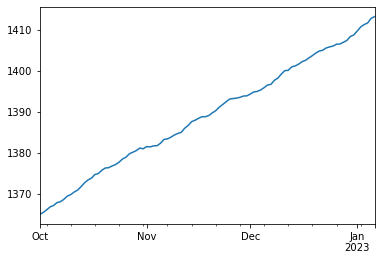

In [6]:
precios=(1+r_simulados).cumprod()*data[-1]

precios.mean(axis=1).plot()
precios.mean(axis=1).tail(1)

Para finalizar con esta parte se realizará un análisis para ver cuál es la probabilidad de que los precios suban entre 1.7% y 10% para saber si esta sería una inversión redituable o no.

La probabilidad de que los precios suban un 1.7% es del **49.97%** aproximadamente, se ve la evolución de la probabilidad de manera gráfica durante las 14 semanas hasta que se alcanza el valor antes mencionado.

0.4997

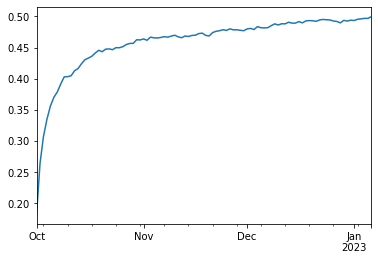

In [8]:
deseado=data[-1]*1.017
sob= precios>=deseado

prob=sob.mean(axis=1)

prob.plot()
prob[-1]

Ahora, la probabilidad de que se obtenga un rendimiento del 10% si se invierte en este tipo de contratos, es del **33.02%**, se ve la evolución de la probabilidad de manera gráfica durante las 14 semanas hasta que se alcanza el valor antes mencionado.

0.3302

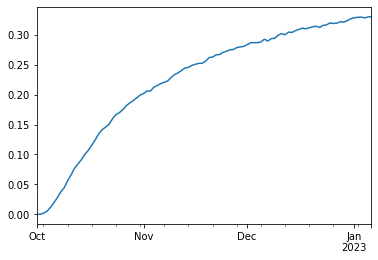

In [11]:
deseado2=data[-1]*1.1
sob2= precios>=deseado2

prob2=sob2.mean(axis=1)

prob2.plot()
prob2[-1]

### Modelo que representa el problema


Ahora es momento de presentar el problema y solución planteados desde la caminata aleatoria.

El precio de la soya se ve afectado por distintos factores que van desde el proceso de siembra hasta el de venta: volatilidad de precios, clima, demanda y oferta. Para este proyecto, proponemos 4 distintos escenarios con su respectiva posibilidad de ocurrencia que involucran a los factores previamente mencionados. 

Los efectos que tendrán los escenarios sobre el precio spot de la soya, en este caso, fueron asignados arbitrariamente, sin embargo sabemos que en la práctica deben obtenerse a partir de un análisis de correlación, para así determinar los escenarios y contabilizar los efectos. La probabilidad de que ocurra cada escenario también tendría que obtenerse de un análisis riguroso de los factores que afectan la volatilidad, expectativas, la oferta y demanda.

Los valores escogidos, de cualquier forma, buscan equilibrar el comportamiento de los precios y tienen una base intuitiva, por ejemplo; pensamos que el escenarios más probable es que la volatilidad del precio tenga un efecto positivo sobre el precio spot, ya que existe el riesgo de que la guerra de Ucrania se agrave, los energéticos se encarezcan, continue la inflación y, por lo tanto, se perciba riesgo, un clima adverso en Brasil, Estados Unidos o América del Sur generaría expectativas de escasez y es probable que la demanda mundial de alimentos aumente, por lo tanto la demanda de productos agroalimentarios, finalmente, la suma de los efectos produce un aumento de 1.7% en el precio semanal de la soya, que es coherente con el crecimiento semanal observado en correcciones (cuando el precio, en general, va para abajo) anteriores y que también es coherente con lo obtenido en la simulación precio umbral.

| Escenario  | Probabilidad  |  Volatilidad (a) | Clima (b)  | Demanda (c)  | Oferta (d)  |
|--- |---    |---     |   ---  |   --- |---    |
| 1  | 0.45  | 0.01   | 0.003  | 0.004 | 0.0   |
| 2  | 0.40  | -0.003 | -0.005 | -0.003 | -0.001   |
| 3  | 0.12  | -0.005  | 0.001  | -0.002 | 0.0   |
| 4  | 0.03  | 0.04   | 0.01   | 0.01  | 0.04  |

Los escenarios representan las probabilidades de que ocurran ciertas condiciones de clima, volatilidad de precios, oferta y demanda y que afectarán al precio de spot la soya. Los valores en las celdas de volatilidad, clima, demanda y oferta representan el cambio porcentual que tendría el precio del commodity con cada semana que se den esas condiciones. El modelo quedaría como

$$ P_{actual}=(P_{anterior})(1+a+b+c+d) $$

### Solución del problema


In [13]:
import pandas as pd
import numpy as np

Se realiza un DataFrame de la tabla que se propone en el planteamiento del problema.

In [14]:
i=np.arange(4)
df=pd.DataFrame(index=i,columns=["a","b","c","d","pi"],dtype="float")
df.index.name="i"

df["a"]=[0.01,-0.003,-0.005,0.04]
df["b"]=[0.003,-0.005,0.001,0.01]
df["c"]=[0.004,-0.003,-0.002,0.01]
df["d"]=[0,-0.001,0,0.04]
df["pi"]=[0.45,0.40,0.12,0.03]
df

,a,b,c,d,pi
i,,,,,
0,0.010,0.003,0.004,0.000,0.45
1,-0.003,-0.005,-0.003,-0.001,0.40
2,-0.005,0.001,-0.002,0.000,0.12
3,0.040,0.010,0.010,0.040,0.03


Utilizando un algoritmo de estilo "*caminata aleatoria*" se comienza a simular el cambio en el precio del bushel tomando un precio inicial, en este caso de $1360 que es el precio al primero de octubre de 2022, se simulan 14 semanas, 10000 veces cada una.

In [15]:
import random

simulaciones=[]
for j in range(10000):
    precio=[13.6] #Precio al primero de octubre de 2022
    for k in range(14):
        i_actual=random.choices(i,weights=df["pi"])
    
        a=float(df["a"][i_actual])
        b=float(df["b"][i_actual])
        c=float(df["c"][i_actual])
        d=float(df["d"][i_actual])
        precio_actual= (precio[-1])*(1+a+b+c+d)
        precio.append(precio_actual)
    simulaciones.append(precio)

In [16]:
simulaciones=np.array(simulaciones)
simulaciones

array([[13.6       , 13.4368    , 13.2755584 , ..., 13.67954728,
        13.91209959, 13.82862699],
       [13.6       , 13.8312    , 13.7482128 , ..., 12.69517172,
        12.54282965, 12.3923157 ],
       [13.6       , 13.5184    , 13.7482128 , ..., 13.84620013,
        14.08158553, 14.32097249],
       ...,
       [13.6       , 13.5184    , 13.7482128 , ..., 13.67954728,
        13.91209959, 13.82862699],
       [13.6       , 13.5184    , 13.7482128 , ..., 13.37017699,
        13.20973487, 13.13047646],
       [13.6       , 13.4368    , 13.2755584 , ..., 16.04006199,
        16.31274304, 16.21486658]])

### Visualización de la solución del problema

Gráficamente se observa el cambio promedio de cada una de las 14 semanas, este toma una tendencia a la alza, pasando del precio inicial de \$1360 a un precio final de aproximadamente **$1460.95**

14    14.609542
dtype: float64

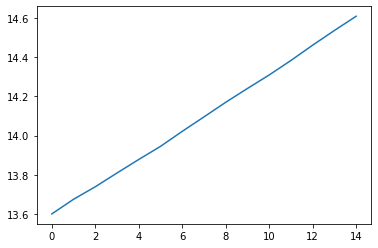

In [17]:
sim = pd.DataFrame(simulaciones)
sim.mean().plot()
sim.mean().tail(1)

### Conclusiones

1. Después de realizar nuestra aproximación por 2 distintos métodos podemos concluir que el precio del bushel de soya para enero de 2023 tendrá un aumento de precio, con simulación precio umbral del 3.9% y con caminata aleatoria de 7.4%
2. Creemos que son aproximaciones útiles pues la variación entre ambos métodos fue únicamente de 43 centavos de dólar. 
3. Aunque el modelo fue propuesto por nosotros, creemos que es acertado puesto que se acerca al precio de la otra aproximación.
4. Comparando la evolución de los precios simulados con ambas técnicas confirmamos que la hipótesis del mercado eficiente y el movimiento Browniano son la base de la simulación precio umbral.


### Referencias

> - Aswini Kumar Mishra (2021). Forecasting spot prices of agricultural commodities in India: Application of deep-learning models. Recuperado de: https://onlinelibrary.wiley.com/doi/abs/10.1002/isaf.1487
> - Blackledge Jonathan (2010). The Fractal Market Hypothesis:Applications to Financial Forecasting; Centre forAdvanced Studies, Warsaw University of Technology , vol: 978-83-61993-01-83, pages: 1 - 105. Recuperado de: https://www.academia.edu/59699980/The_fractal_market_hypothesis_applications_to_financial_forecasting
> - Liberto Daniel (2021). Fractal Markets Hypothesis (FMH). Investopedia. Recuperado de: https://www.investopedia.com/terms/f/fractal-markets-hypothesis-fmh.asp#:~:text=The%20fractal%20markets%20hypothesis%20%28FMH%29%20is%20a%20theory,information%20sets%20and%20time%20horizons%20of%20investors%20change.
> - Soybean Futures, current, CBOT. https://www.tradingview.com/chart/plYfU66F/?symbol=CBOT%3AZS1%21
> - Statista. (2022, 28 julio). Los diez principales exportadores de soja en el mundo en 2021. https://es.statista.com/estadisticas/1129461/principales-paises-exportadores-de-soja-en-el-mundo/
> - Wikipedia contributors. (2022, 29 septiembre). Lévy 
distribution.https://en.wikipedia.org/wiki/L%C3%A9vy_distribution
